In [1]:
# use model as ViViT model or slowfast model
import torch
import pandas as pd
import matplotlib.pyplot as plt
from src.CustomDataset import CustomDataset
from torch.utils.data import DataLoader

/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.utils.utility import show_data_composition
show_data_composition("./dataset/dur21_dis0/")

########### Total Dataset Composition ########### 
disruption :  82
normal :  8166
########### Train Dataset Composition ########### 
disruption :  34
normal :  4896
########### Valid Dataset Composition ########### 
disruption :  24
normal :  1632
########### Test Dataset Composition ########### 
disruption :  24
normal :  1638


/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/torchvision/transforms/_functional_video.py:5: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  warnings.warn(
/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/torchvision/transforms/_transforms_video.py:25: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  warnings.warn(


In [3]:
new_shot_df = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv")
new_shot_df.head()

,shot,year,tftsrt,tipminf,tTQend,dt,frame_cutoff,frame_tTQend,frame_tipminf
0,21273,2018,2.996,5.535,5.514,0.021,1165,1160,1164
1,21274,2018,2.996,10.056,10.038,0.018,2104,2100,2103
2,21310,2018,1.500,5.368,5.342,0.026,1131,1125,1130
3,21315,2018,1.500,7.804,7.782,0.022,1636,1631,1635
4,21317,2018,1.500,9.460,9.438,0.022,1980,1975,1979


In [4]:
import numpy as np
np.unique(new_shot_df.year.values)

array([2018])

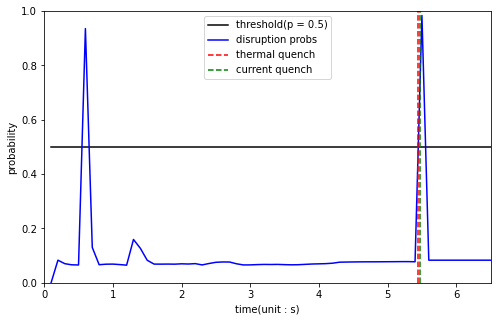

In [5]:
from src.models.ViViT import ViViT
import os

model = ViViT(
    image_size = 128,
    patch_size = 32,
    n_classes = 2,
    n_frames = 21,
    dim = 64,
    depth = 4,
    n_heads = 8,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

# torch cuda initialize and clear cache
torch.cuda.init()
torch.cuda.empty_cache()

# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:" + str(3)
else:
    device = 'cpu'

model.to(device)

model.load_state_dict(torch.load("./weights/ViViT_clip_21_dist_0_best.pt"))

from src.utils.utility import generate_prob_curve, video2tensor

# shot_num = 21747
shot_num = 21310

video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)

dataset = video2tensor(video_dir, 3, 21, 128, 256,256, False)
prob_list = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 32, 
    device = device, 
    save_dir = "./results/ViViT_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 21,
    dist_frame = 0,
    use_continuous_frame = False
)

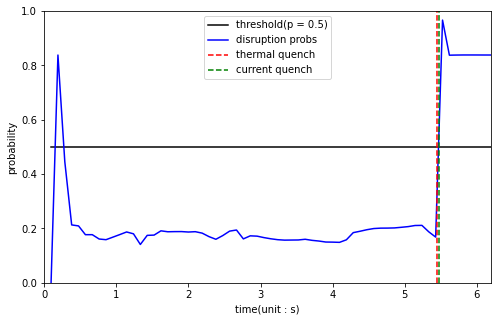

In [6]:
from src.models.slowfast import SlowFast
from src.models.resnet import Bottleneck3D

model = SlowFast(
        input_shape = (3, 20, 224, 224),
        block = Bottleneck3D,
        layers = [1,2,2,1],
        alpha = 4,
        tau_fast = 1,
        mlp_hidden = 64,
        num_classes = 2,
        device = device
)

model.to(device)
model.load_state_dict(torch.load("./weights/slowfast_clip_21_dist_0_best.pt"))

dataset = video2tensor(video_dir, 3, 20, 128, 256,256, False)
prob_list = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 32, 
    device = device, 
    save_dir = "./results/slowfast_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 20,
    dist_frame = 0,
    use_continuous_frame = False
)

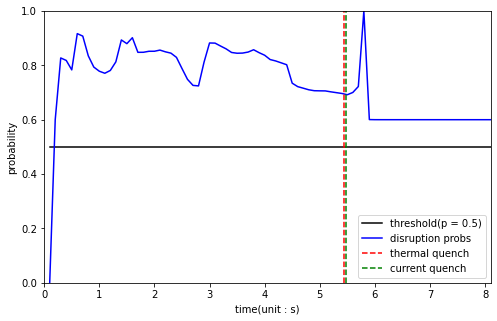

In [8]:
from src.models.R2Plus1D import  R2Plus1DClassifier

model = R2Plus1DClassifier(
        input_size  = (3, 21, 128, 128),
        num_classes = 2, 
        layer_sizes = [1,2,2,1], 
        pretrained = False, 
        alpha = 0.01
    )

model.to(device)
model.load_state_dict(torch.load("./weights/R2Plus1D_clip_21_dist_0_best.pt"))

dataset = video2tensor(video_dir, 3, 20, 128, 256,256, False)
prob_list = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 16, 
    device = device, 
    save_dir = "./results/R2Plus1D_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 21,
    dist_frame = 0,
    use_continuous_frame = False
)

Distance = 3 frame (about 15ms) for prediction

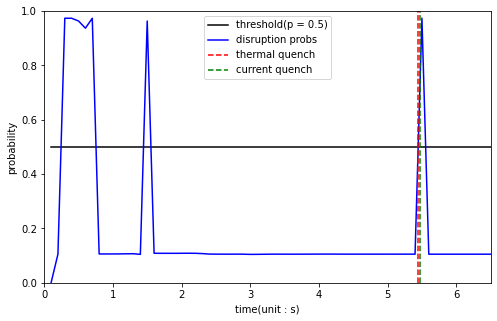

In [6]:
from src.models.ViViT import ViViT
import os

model = ViViT(
    image_size = 128,
    patch_size = 32,
    n_classes = 2,
    n_frames = 21,
    dim = 64,
    depth = 4,
    n_heads = 8,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

# torch cuda initialize and clear cache
torch.cuda.init()
torch.cuda.empty_cache()

# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:" + str(3)
else:
    device = 'cpu'
    
model.to(device)

model.load_state_dict(torch.load("./weights/ViViT_clip_21_dist_3_best.pt"))

from src.utils.utility import generate_prob_curve, video2tensor

# shot_num = 21747
shot_num = 21310

video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)
dataset = video2tensor(video_dir, 3, 21, 128, 256,256, False)
prob_list = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 64, 
    device = device, 
    save_dir = "./results/ViViT_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 21,
    dist_frame = 3,
    use_continuous_frame = False
)

Now, Distance = 5 frame (about 25ms) for prediction

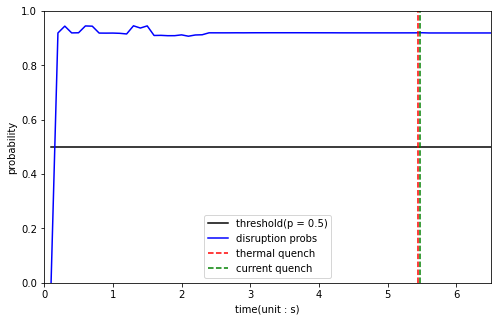

In [10]:
from src.models.ViViT import ViViT
import os

model = ViViT(
    image_size = 128,
    patch_size = 32,
    n_classes = 2,
    n_frames = 21,
    dim = 64,
    depth = 4,
    n_heads = 8,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

model.to(device)

model.load_state_dict(torch.load("./weights/ViViT_clip_21_dist_5_best.pt"))

from src.utils.utility import generate_prob_curve, video2tensor

# shot_num = 21747
shot_num = 21310

video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)
dataset = video2tensor(video_dir, 3, 21, 128, 256,256, False)
prob_list = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 64, 
    device = device, 
    save_dir = "./results/ViViT_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 21,
    dist_frame = 5,
    use_continuous_frame = False
)

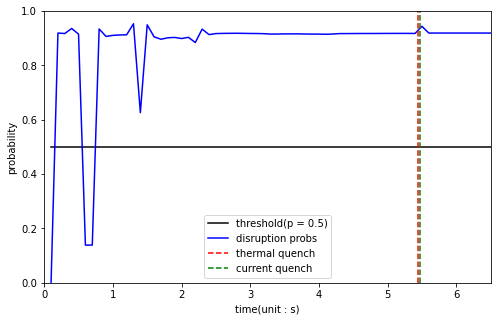

In [11]:
from src.models.ViViT import ViViT
import os

model = ViViT(
    image_size = 128,
    patch_size = 32,
    n_classes = 2,
    n_frames = 21,
    dim = 64,
    depth = 4,
    n_heads = 8,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

model.to(device)

model.load_state_dict(torch.load("./weights/ViViT_clip_21_dist_5_best.pt"))

from src.utils.utility import generate_prob_curve, video2tensor

# shot_num = 21747
shot_num = 21310

video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)
dataset = video2tensor(video_dir, 3, 21, 128, 256,256, False)
prob_list = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 64, 
    device = device, 
    save_dir = "./results/ViViT_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 21,
    dist_frame = 5,
    use_continuous_frame = False
)

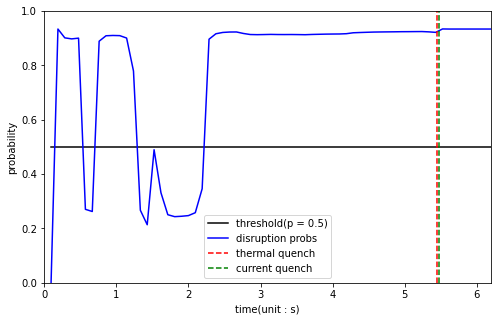

In [9]:
from src.models.slowfast import SlowFast
from src.models.resnet import Bottleneck3D

shot_num = 21310
video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)
dataset = video2tensor(video_dir, 3, 21, 128, 256,256, False)

model = SlowFast(
        input_shape = (3, 20, 224, 224),
        block = Bottleneck3D,
        layers = [1,2,2,1],
        alpha = 4,
        tau_fast = 1,
        mlp_hidden = 64,
        num_classes = 2,
        device = device
)

model.to(device)
model.load_state_dict(torch.load("./weights/slowfast_clip_21_dist_5_best.pt"))

dataset = video2tensor(video_dir, 3, 20, 128, 256,256, False)
prob_list = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 64, 
    device = device, 
    save_dir = "./results/slowfast_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 20,
    dist_frame = 5,
    use_continuous_frame = False
)

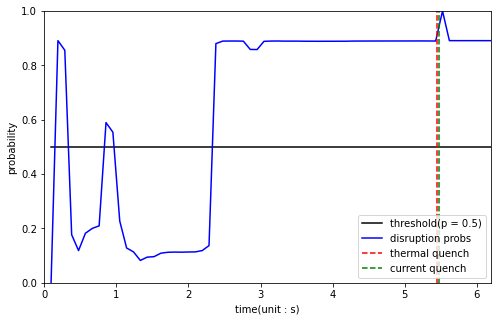

In [12]:
from src.models.slowfast import SlowFast
from src.models.resnet import Bottleneck3D

shot_num = 21310
video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)
dataset = video2tensor(video_dir, 3, 21, 128, 256,256, False)

model = SlowFast(
        input_shape = (3, 20, 224, 224),
        block = Bottleneck3D,
        layers = [1,2,2,1],
        alpha = 4,
        tau_fast = 1,
        mlp_hidden = 64,
        num_classes = 2,
        device = device
)

model.to(device)
model.load_state_dict(torch.load("./weights/slowfast_clip_21_dist_5_best.pt"))

dataset = video2tensor(video_dir, 3, 20, 128, 256,256, False)
prob_list = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 64, 
    device = device, 
    save_dir = "./results/slowfast_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 20,
    dist_frame = 5,
    use_continuous_frame = False
)

Experiment Result for different algorithm

<AxesSubplot:xlabel='Loss', ylabel='F1_score'>

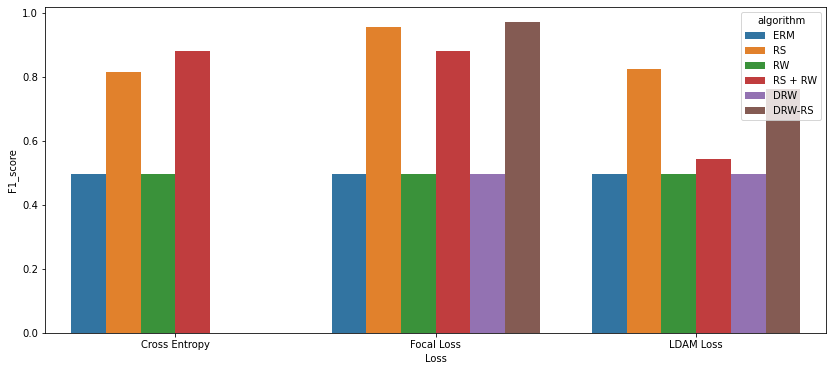

In [13]:
# plot as a bar graph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

algorithm_list = ['ERM', 'RS', 'RW', 'RS + RW'] + ['ERM', 'RS', 'RW', 'RS + RW', 'DRW', 'DRW-RS'] + ['ERM', 'RS', 'RW', 'RS + RW', 'DRW', 'DRW-RS']
loss_list = ['Cross Entropy'] * 4 + ['Focal Loss'] * 6 + ['LDAM Loss'] * 6
f1_list = [0.496, 0.813, 0.496, 0.880] + [0.496, 0.956, 0.496, 0.88, 0.496, 0.97] + [0.496, 0.824, 0.496, 0.543, 0.496, 0.76]

df_exp_algorithm = pd.DataFrame({
    "Loss" : loss_list,
    "F1_score" : f1_list,
    "algorithm" : algorithm_list
})

plt.figure(figsize = (14,6))
sns.barplot(data = df_exp_algorithm, x = 'Loss', y = 'F1_score', hue = 'algorithm')

Image sequence vs 0D data vs Probability Curve Plot

In [5]:
shot_num = 21310
df_0D = pd.read_csv("./dataset/KSTAR_Disruption_ts_data_extend.csv")

In [45]:
ts_data_0D = df_0D[df_0D.shot == shot_num]
ts_data_0D.head()

,Unnamed: 0,time,shot,\q95,\ipmhd,\kappa,\tritop,\tribot,\betap,\betan,...,\TS_EDGE7:EDGE7_NE,\TS_EDGE8:EDGE8_NE,\TS_EDGE9:EDGE9_NE,\TS_EDGE10:EDGE10_NE,\TS_EDGE11:EDGE11_NE,\TS_EDGE12:EDGE12_NE,\TS_EDGE13:EDGE13_NE,\TS_EDGE14:EDGE14_NE,\TS_EDGE15:EDGE15_NE,frame_idx
1617322,0,0.000000,21310,1061.016362,-108528.127480,0.855080,-0.048230,-0.048230,0.586226,0.408722,...,1.226222e+18,4.373478e+18,4.647083e+16,7.580386e+19,2.554893e+18,0.0,0.0,NaN,NaN,0
1617323,1,0.004762,21310,1053.159236,-110324.624076,0.858013,-0.047193,-0.047193,0.585626,0.410122,...,1.227407e+18,4.331649e+18,4.857463e+16,7.497099e+19,2.536799e+18,0.0,0.0,NaN,NaN,1
1617324,2,0.009524,21310,1045.302110,-112121.120671,0.860947,-0.046156,-0.046156,0.585026,0.411522,...,1.228592e+18,4.289820e+18,5.067843e+16,7.413813e+19,2.518705e+18,0.0,0.0,NaN,NaN,2
1617325,3,0.014286,21310,1037.444983,-113917.617267,0.863880,-0.045118,-0.045118,0.584426,0.412922,...,1.229778e+18,4.247992e+18,5.278223e+16,7.330526e+19,2.500611e+18,0.0,0.0,NaN,NaN,3
1617326,4,0.019048,21310,1029.587857,-115714.113862,0.866813,-0.044081,-0.044081,0.583825,0.414322,...,1.230963e+18,4.206163e+18,5.488603e+16,7.247240e+19,2.482517e+18,0.0,0.0,NaN,NaN,4


In [46]:
ts_data_0D.columns

Index(['Unnamed: 0', 'time', 'shot', '\q95', '\ipmhd', '\kappa', '\tritop',
       '\tribot', '\betap', '\betan', '\li', '\bcentr', '\nb11_pnb',
       '\nb12_pnb', '\nb13_pnb', '\ne_inter01', '\ne_tci01', '\ne_tci02',
       '\RC03', '\VCM03', '\WTOT_DLM03', '\TS_CORE1:CORE1_TE',
       '\TS_CORE2:CORE2_TE', '\TS_CORE3:CORE3_TE', '\TS_CORE4:CORE4_TE',
       '\TS_CORE5:CORE5_TE', '\TS_CORE6:CORE6_TE', '\TS_CORE7:CORE7_TE',
       '\TS_CORE8:CORE8_TE', '\TS_CORE9:CORE9_TE', '\TS_CORE10:CORE10_TE',
       '\TS_CORE11:CORE11_TE', '\TS_CORE12:CORE12_TE', '\TS_CORE13:CORE13_TE',
       '\TS_CORE14:CORE14_TE', '\TS_EDGE1:EDGE1_TE', '\TS_EDGE2:EDGE2_TE',
       '\TS_EDGE3:EDGE3_TE', '\TS_EDGE4:EDGE4_TE', '\TS_EDGE5:EDGE5_TE',
       '\TS_EDGE6:EDGE6_TE', '\TS_EDGE7:EDGE7_TE', '\TS_EDGE8:EDGE8_TE',
       '\TS_EDGE9:EDGE9_TE', '\TS_EDGE10:EDGE10_TE', '\TS_EDGE11:EDGE11_TE',
       '\TS_EDGE12:EDGE12_TE', '\TS_EDGE13:EDGE13_TE', '\TS_EDGE14:EDGE14_TE',
       '\TS_EDGE15:EDGE15_TE', '\TS_CORE1

In [47]:
t_TQend = new_shot_df[new_shot_df.shot==shot_num]['tTQend'].values[0]
t_ipminf = new_shot_df[new_shot_df.shot==shot_num]['tipminf'].values[0]

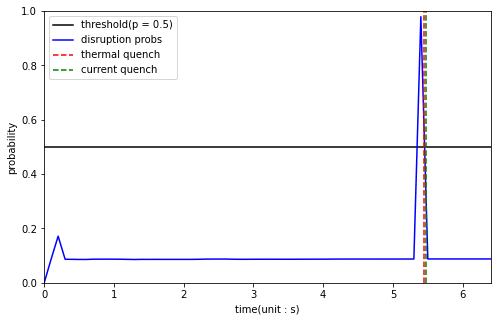

In [7]:
from src.models.ViViT import ViViT
import os

model = ViViT(
    image_size = 128,
    patch_size = 32,
    n_classes = 2,
    n_frames = 21,
    dim = 64,
    depth = 4,
    n_heads = 8,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

# torch cuda initialize and clear cache
torch.cuda.init()
torch.cuda.empty_cache()

# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:" + str(3)
else:
    device = 'cpu'

model.to(device)
model.load_state_dict(torch.load("./weights/ViViT_clip_21_dist_0_best.pt"))

from src.utils.utility import generate_prob_curve, video2tensor
video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)

dataset = video2tensor(video_dir, 3, 21, 128, 256,256, False)
time_x, prob_list = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 32, 
    device = device, 
    save_dir = "./results/ViViT_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 21,
    dist_frame = 0,
    use_continuous_frame = False
)

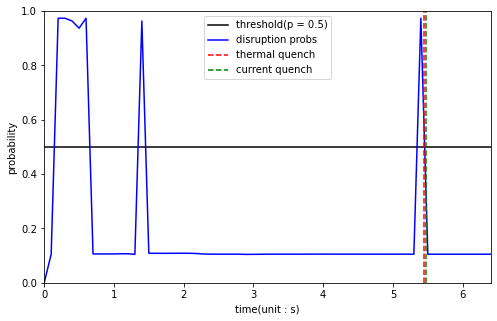

In [60]:
from src.models.ViViT import ViViT
import os

model = ViViT(
    image_size = 128,
    patch_size = 32,
    n_classes = 2,
    n_frames = 21,
    dim = 64,
    depth = 4,
    n_heads = 8,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

# torch cuda initialize and clear cache
torch.cuda.init()
torch.cuda.empty_cache()

# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:" + str(3)
else:
    device = 'cpu'

model.to(device)
model.load_state_dict(torch.load("./weights/ViViT_clip_21_dist_3_best.pt"))

from src.utils.utility import generate_prob_curve, video2tensor
video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)

dataset = video2tensor(video_dir, 3, 21, 128, 256,256, False)
time_x_dist3, prob_list_dist3 = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 32, 
    device = device, 
    save_dir = "./results/ViViT_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 21,
    dist_frame = 3,
    use_continuous_frame = False
)

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
col = ['\\ipmhd','\\kappa','\\betap','\\betan', '\\li', '\\bcentr', '\\q95', '\\tritop', '\\tribot', '\\WTOT_DLM03', '\\ne_inter01', '\\TS_CORE10:CORE10_TE']
ts_data_0D[col] = scaler.fit_transform(ts_data_0D[col].values)

/tmp/ipykernel_2550685/530925373.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_data_0D[col] = scaler.fit_transform(ts_data_0D[col].values)
/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [49]:
t = ts_data_0D.time
ip = ts_data_0D['\\ipmhd']
kappa = ts_data_0D['\\kappa']
betap = ts_data_0D['\\betap']
betan = ts_data_0D['\\betan']
li = ts_data_0D['\\li']
Bc = ts_data_0D['\\bcentr']
q95 = ts_data_0D['\\q95']
tritop = ts_data_0D['\\tritop']
tribot = ts_data_0D['\\tribot']
W_tot = ts_data_0D['\\WTOT_DLM03']
ne = ts_data_0D['\\ne_inter01']
te = ts_data_0D['\\TS_CORE10:CORE10_TE']

Text(0, 0.5, 'Probability')

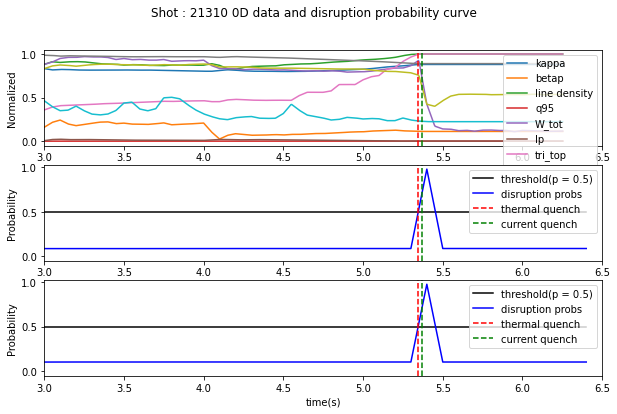

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (10,6), sharex = False)
fig.suptitle("Shot : {} 0D data and disruption probability curve".format(shot_num))
ax1.plot(t, kappa, label = "kappa")
ax1.plot(t, betap, label = 'betap')
ax1.plot(t, li, label = 'line density')
ax1.plot(t, q95, label = 'q95')
ax1.plot(t, W_tot, label = 'W_tot')
ax1.plot(t, ip, label = 'Ip')
ax1.plot(t, tritop, label = 'tri_top')
ax1.plot(t, tribot, label = 'tri_bot')
ax1.plot(t, ne, label = 'ne')
ax1.plot(t, te, label = 'Te')
ax1.set_xlim([3,6.5])
ax1.axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", )
ax1.axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed")
ax1.legend()
ax1.set_xlabel("time(s)")
ax1.set_ylabel("Normalized")

threshold_line = [0.5] * len(time_x)
ax2.plot(time_x, threshold_line, 'k', label = "threshold(p = 0.5)")
ax2.plot(time_x, prob_list, 'b-', label = "disruption probs")
ax2.axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", label = "thermal quench")
ax2.axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed", label = "current quench")
ax2.legend()
ax2.set_xlim([3,6.5])
ax2.set_xlabel("time(s)")
ax2.set_ylabel("Probability")

threshold_line = [0.5] * len(time_x)
ax3.plot(time_x_dist3, threshold_line, 'k', label = "threshold(p = 0.5)")
ax3.plot(time_x_dist3, prob_list_dist3, 'b-', label = "disruption probs")
ax3.axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", label = "thermal quench")
ax3.axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed", label = "current quench")
ax3.legend()
ax3.set_xlim([3,6.5])
ax3.set_xlabel("time(s)")
ax3.set_ylabel("Probability")

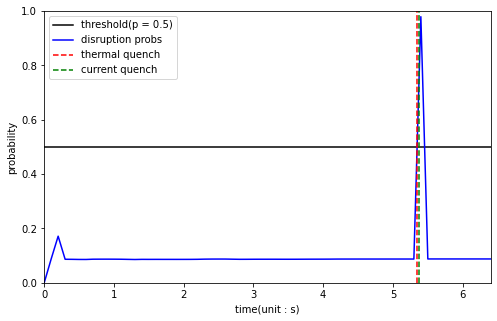

In [17]:
threshold_line = [0.5] * len(time_x)

plt.figure(figsize = (8,5), facecolor = 'white')
plt.plot(time_x, threshold_line, 'k', label = "threshold(p = 0.5)")
plt.plot(time_x, prob_list, 'b-', label = "disruption probs")

plt.axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", label = "thermal quench")
plt.axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed", label = "current quench")

plt.ylabel("probability")
plt.xlabel("time(unit : s)")
plt.ylim([0,1])
plt.xlim([0,max(time_x)])
plt.legend()